In [1]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative

In [3]:
#sorting the data in ascending order according to the time stamp
temp.sort_values('Time', inplace=True)
temp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [4]:
#getting rid of the duplicates
final = temp.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Removing all the points where Denominator < Numerator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [6]:
final.shape

(364171, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

#### Doing the text processing for text as well as summary of the review

In [7]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [8]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Text'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 364171/364171 [06:30<00:00, 932.04it/s] 


In [9]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [10]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [11]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Summary'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 364171/364171 [00:27<00:00, 13100.76it/s]


In [12]:
final['CleanedSummary']=final_string 
final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")

In [13]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [14]:
#Saving the cleaned data for future assignments
clean_data = open("clean_data_1.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [2]:
pickle_in = open("clean_data_1.pickle", "rb")
final = pickle.load(pickle_in)

In [3]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [4]:
final.shape

(364171, 12)

In [5]:
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,364171):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(364171,)

# Dividing the whole data into train, CV and test sets

In [6]:
#train data
X_train = final[0: 218502]
Y_train = final_scores[0: 218502]
print(X_train.shape)
print(Y_train.shape)

(218502, 12)
(218502,)


In [7]:
X_CV = final[218502: 291330]
Y_CV = final_scores[218502: 291330]
print(X_CV.shape)
print(Y_CV.shape)

(72828, 12)
(72828,)


In [8]:
#test data
X_test = final[291330: ]
Y_test = final_scores[291330: ]
print(X_test.shape)
print(Y_test.shape)

(72841, 12)
(72841,)


## Here we will use the Multinomial version of Naive Bayes algorithm because we will work with BOW and TF-IDF vectorizer which doesn't contain binomial features.

# BOW

In [9]:
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(218502, 54841)

In [10]:
train_bow = open("train_bow.pickle", "wb")
pickle.dump(X_train_bow, train_bow)
train_bow.close()

In [11]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(72828, 54841)

In [12]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(72841, 54841)

In [13]:
test_bow = open("test_bow.pickle", "wb")
pickle.dump(X_test_bow, test_bow)
test_bow.close()

#  Multinomial Naive Bayes on BOW

In [14]:
def scores(x, y):
    alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    scores = []
    for a in alphas:
        NB = MultinomialNB(alpha=a, fit_prior=True, class_prior=None)
        NB.fit(X_train_bow, Y_train)
        pred = NB.predict(x)
        auc = roc_auc_score(y, pred)
        scores.append(auc)
    return scores

In [15]:
##getting the training scores.
train_scores = scores(X_train_bow, Y_train)

In [16]:
##getting the cross validation scores.
cv_scores = scores(X_CV_bow, Y_CV)

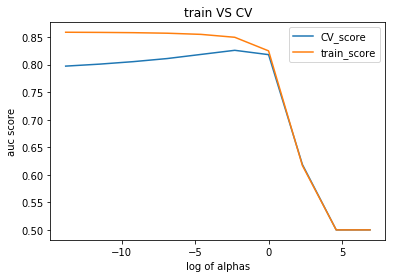

In [17]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
log_alphas = np.log(np.asarray(alphas))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

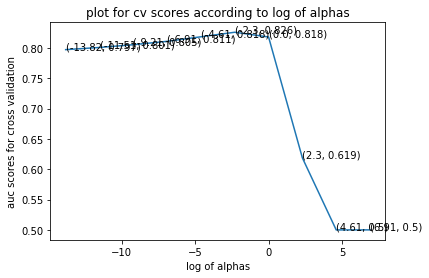

The auc score for each alpha value for cross validation is :  [0.797 0.801 0.805 0.811 0.818 0.826 0.818 0.619 0.5   0.5  ]


In [18]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

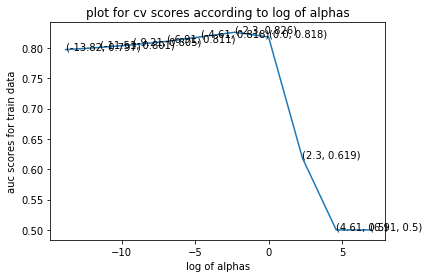

The auc score for each alpha value for train data is :  [0.859 0.858 0.858 0.857 0.855 0.85  0.825 0.617 0.5   0.5  ]


In [19]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [20]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
optimal_alpha_for_cv = alphas[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha for cv is {} and it\'s value is {}'.format(optimal_alpha_for_cv, max(cv_scores)))


The optimal value of alpha for cv is 0.1 and it's value is 0.8259381843103824


In [21]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
optimal_alpha_for_train = alphas[train_scores.index(max(train_scores))]
print('\nThe optimal value of alpha for training is {} and it\'s value is {}'.format(optimal_alpha_for_train, max(train_scores)))


The optimal value of alpha for training is 1e-06 and it's value is 0.8587301921027681


In [22]:
x = PrettyTable()
x.field_names = ['alphas for cv', 'cv score', 'alphas for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([alphas[cv_scores.index(z)], z, alphas[train_scores.index(y)], y])
print(x)

+---------------+--------------------+------------------+---------------------+
| alphas for cv |      cv score      | alphas for train |     train score     |
+---------------+--------------------+------------------+---------------------+
|      0.1      | 0.8259381843103824 |      1e-06       |  0.8587301921027681 |
|      0.01     | 0.8184611269912909 |      1e-05       |  0.858447505557637  |
|       1       | 0.8180783310766763 |      0.0001      |   0.85794858419894  |
|     0.001     | 0.8109757116827976 |      0.001       |  0.8569717508034586 |
|     0.0001    | 0.8053708439897699 |       0.01       |  0.8548683283850209 |
|     1e-05     | 0.8008374705380874 |       0.1        |  0.8495842156492831 |
|     1e-06     | 0.7972435350951974 |        1         |  0.8249147359653185 |
|       10      | 0.6186466743560168 |        10        |  0.6168536987476079 |
|      1000     |        0.5         |       1000       | 0.49999711744422876 |
|      100      | 0.499943165672066  |  

## Based on the above graphs and the table we can choose the optimal value of alpha to be equal to 0.01

In [23]:
NB_optimal = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)

# fitting the model
NB_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = NB_optimal.predict(X_test_bow)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [24]:
print('\nThe auc score for test data for alpha = {} is {:2f}'.format(0.01, auc_score))


The auc score for test data for alpha = 0.01 is 0.811599


In [25]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 8680,  3860],
       [ 4160, 56141]])

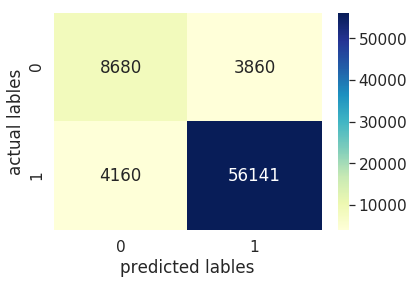

In [26]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [27]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.68      0.69      0.68     12540
          1       0.94      0.93      0.93     60301

avg / total       0.89      0.89      0.89     72841



## Top 20 features for positive class and top 20 features for negative class

In [28]:
def show_most_informative_features(vectorizer, clf, n=20):
    print('The below table shows us the top 20 features and there corresponding feature names for negative and positive class')
    print()
    x = PrettyTable()
    x.field_names = ["value for negative features",
                     "negative features",
                     "value for positive features",
                     "positive features"]
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns_negative = sorted(zip(np.absolute(clf.feature_log_prob_[0]), feature_names))
    coefs_with_fns_positive = sorted(zip(np.absolute(clf.feature_log_prob_[1]), feature_names))
    top = zip(coefs_with_fns_negative[:n], coefs_with_fns_positive[:n])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        x.add_row([coef_1, fn_1, coef_2, fn_2])
    print(x)

In [29]:
show_most_informative_features(count_vect, NB_optimal)

The below table shows us the top 20 features and there corresponding feature names for negative and positive class

+-----------------------------+-------------------+-----------------------------+-------------------+
| value for negative features | negative features | value for positive features | positive features |
+-----------------------------+-------------------+-----------------------------+-------------------+
|      4.1996549763316775     |        tast       |      4.436274334610291      |        like       |
|      4.285497771530531      |        like       |      4.504058800456033      |        tast       |
|      4.447037734039206      |      product      |      4.640597341544273      |        good       |
|      4.719593224599658      |        one        |      4.668583932091005      |       flavor      |
|       4.78539578915095      |       flavor      |      4.6992017805576864     |        love       |
|      4.882157811157894      |        tri        |      4.715782093

# TF-IDF

In [9]:
tf_idf_vect = TfidfVectorizer()
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_tfidf.shape

(218502, 54841)

In [10]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
X_CV_tfidf.shape

(72828, 54841)

In [11]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_tfidf.shape

(72841, 54841)

# Multinomial Naive Bayes on TF-IDF

In [15]:
def scores(x, y):
    alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    scores = []
    for a in alphas:
        NB = MultinomialNB(alpha=a, fit_prior=True, class_prior=None)
        NB.fit(X_train_tfidf, Y_train)
        pred = NB.predict(x)
        auc = roc_auc_score(y, pred)
        scores.append(auc)
    return scores

In [16]:
cv_scores = scores(X_CV_tfidf, Y_CV)

In [17]:
train_scores = scores(X_train_tfidf, Y_train)

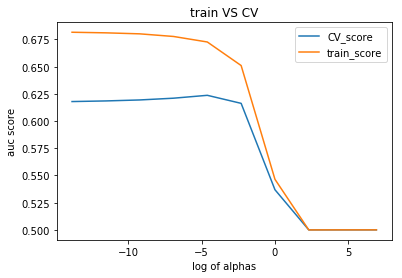

In [18]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
log_alphas = np.log(np.asarray(alphas))
plt.plot(log_alphas, cv_scores, label='CV_score')
plt.plot(log_alphas, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of alphas')
plt.legend()
plt.show()

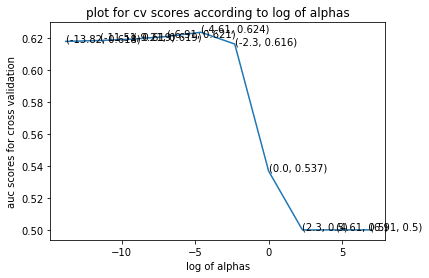

The auc score for each alpha value for cross validation is :  [0.618 0.619 0.619 0.621 0.624 0.616 0.537 0.5   0.5   0.5  ]


In [19]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each alpha value for cross validation is : ", np.round(cv_scores,3))

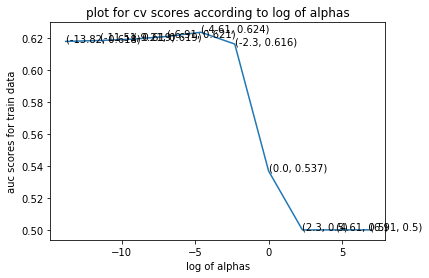

The auc score for each alpha value for train data is :  [0.682 0.681 0.68  0.678 0.673 0.651 0.546 0.5   0.5   0.5  ]


In [20]:
plt.plot(log_alphas, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_alphas, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of alphas')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each alpha value for train data is : ", np.round(train_scores,3))

In [21]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
optimal_alpha_for_cv = alphas[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha for cv is {} and it\'s value is {}'.format(optimal_alpha_for_cv, max(cv_scores)))


The optimal value of alpha for cv is 0.01 and it's value is 0.6236898851612256


In [22]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
optimal_alpha_for_train = alphas[train_scores.index(max(train_scores))]
print('\nThe optimal value of alpha for training is {} and it\'s value is {}'.format(optimal_alpha_for_train, max(train_scores)))


The optimal value of alpha for training is 1e-06 and it's value is 0.6816675854767289


In [23]:
x = PrettyTable()
x.field_names = ['alphas for cv', 'cv score', 'alphas for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([alphas[cv_scores.index(z)], z, alphas[train_scores.index(y)], y])
print(x)

+---------------+---------------------+------------------+--------------------+
| alphas for cv |       cv score      | alphas for train |    train score     |
+---------------+---------------------+------------------+--------------------+
|      0.01     |  0.6236898851612256 |      1e-06       | 0.6816675854767289 |
|     0.001     |  0.6210387309228892 |      1e-05       | 0.6811209901807692 |
|     0.0001    |  0.6194256389682897 |      0.0001      | 0.6801991606573461 |
|     1e-05     |  0.6185263193086271 |      0.001       | 0.6777879244471541 |
|     1e-06     |  0.6179529612356451 |       0.01       | 0.6727122146129866 |
|      0.1      |  0.6163030941276766 |       0.1        | 0.6510652611618026 |
|       1       |  0.5368971800143758 |        1         | 0.5464719381979704 |
|      100      |         0.5         |       100        |        0.5         |
|      100      |         0.5         |       100        |        0.5         |
|       10      | 0.49998328402119585 | 

## From the above graphs and the table I can say that optimal value of alpha should be 0.0001

In [24]:
NB_optimal = MultinomialNB(alpha=0.0001, fit_prior=True, class_prior=None)

# fitting the model
NB_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = NB_optimal.predict(X_test_tfidf)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [27]:
print('\nThe auc score for test data for alpha = {} is {:2f}'.format(0.0001, auc_score))


The auc score for test data for alpha = 0.0001 is 0.616946


In [28]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 3058,  9482],
       [  601, 59700]])

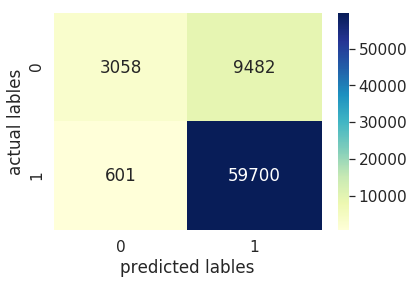

In [29]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [30]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.84      0.24      0.38     12540
          1       0.86      0.99      0.92     60301

avg / total       0.86      0.86      0.83     72841



## Top 20 features for positive class and top 20 features for negative class

In [33]:
def show_most_informative_features(vectorizer, clf, n):
    print('The below table shows us the top 20 features and there corresponding feature names for negative and positive class')
    print()
    x = PrettyTable()
    x.field_names = ["value for negative features",
                     "negative features",
                     "value for positive features",
                     "positive features"]
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns_negative = sorted(zip(np.absolute(clf.feature_log_prob_[0]), feature_names))
    coefs_with_fns_positive = sorted(zip(np.absolute(clf.feature_log_prob_[1]), feature_names))
    top = zip(coefs_with_fns_negative[:n], coefs_with_fns_positive[:n])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        x.add_row([coef_1, fn_1, coef_2, fn_2])
    print(x)

In [36]:
show_most_informative_features(tf_idf_vect, NB_optimal, 20)

The below table shows us the top 20 features and there corresponding feature names for negative and positive class

+-----------------------------+-------------------+-----------------------------+-------------------+
| value for negative features | negative features | value for positive features | positive features |
+-----------------------------+-------------------+-----------------------------+-------------------+
|      4.825712864800832      |        tast       |      5.065026277429013      |       great       |
|      4.976909032397861      |        like       |      5.080424022797917      |        love       |
|       5.01972060864707      |      product      |      5.137864756368659      |        tast       |
|      5.328611004733631      |       would       |      5.1406145010989786     |        good       |
|      5.348199549402401      |       flavor      |      5.154865912464322      |        tea        |
|      5.352142219436123      |       coffe       |      5.155050444

## Comparison between the above two models

In [38]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha Value", "AUC Score on the test data"]
x.add_row(['BOW', 'Mutinomial Naive Bayes', '0.01', '0.8115'])
x.add_row(['TF-IDF', 'Mutinomial Naive Bayes', '0.0001', '0.6169'])
print(x)

+------------+------------------------+-------------+----------------------------+
| Vectorizer |         Model          | Alpha Value | AUC Score on the test data |
+------------+------------------------+-------------+----------------------------+
|    BOW     | Mutinomial Naive Bayes |     0.01    |           0.8115           |
|   TF-IDF   | Mutinomial Naive Bayes |    0.0001   |           0.6200           |
+------------+------------------------+-------------+----------------------------+


### From the above comprison we can see that the model with BOW vectorizer performed better than TF-IDF vectorizer model although the alpha value of BOW vectorizer is greater than TF-IDF vectorizer model.